關於 ```Stock_RET.xlsx```:  
- ```PERMNO```: 股票的代號
- ```date```: 月資料 (每月最後一天計算一次報酬)
- ```EXCHCD```: 交易所代號 (```1``` 表示紐約交易所...)
- ```RET```: 報酬
- ```ME```: 市值 (股價 * 在外流通股數)

關於 ```Stock_BM.xlsx```:  
- ```PERMNO```: 股票的代號
- ```date```: 月資料 (每月最後一天計算一次報酬)
- ```BM```: Book to market Ratio (**每年 6 月更新一次淨值，因為會計準則)**)

## 引入 **個股報酬**，**個股市值**

In [70]:
import numpy as np
import pandas as pd

df = pd.read_csv("Stock_RET.csv")
df.dtypes # should turn the date from int to datetime, turn the RET from object to number

PERMNO      int64
date        int64
EXCHCD      int64
RET        object
ME        float64
dtype: object

In [71]:
df.head(3)

,PERMNO,date,EXCHCD,RET,ME
0,10001,20160129,2,0.116779,87.40160
1,10001,20160229,2,-0.055288,82.56930
2,10001,20160331,2,-0.006361,82.06748


In [72]:
# offsets().MonthEnd(0):
#   offsets(): 使 data 變成每月的最後一天 (見下方 egg)
df.date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')+ pd.offsets.MonthEnd(0)

df.EXCHCD = pd.to_numeric(df.EXCHCD, errors='coerce')
df.RET = pd.to_numeric(df.RET, errors='coerce')
df.ME = pd.to_numeric(df.ME, errors='coerce')

df = df.set_index(["date", "PERMNO"]) # 把 date 與 PERMNO columns 設為 index

df.head(3)

,,EXCHCD,RET,ME
date,PERMNO,,,
2016-01-31,10001,2,0.116779,87.40160
2016-02-29,10001,2,-0.055288,82.56930
2016-03-31,10001,2,-0.006361,82.06748


---

In [73]:
egg = pd.read_csv("Stock_RET.csv")
egg.date = pd.to_datetime(egg.date, format='%Y%m%d', errors='ignore')
egg.head(5)


,PERMNO,date,EXCHCD,RET,ME
0,10001,2016-01-29,2,0.116779,87.40160
1,10001,2016-02-29,2,-0.055288,82.56930
2,10001,2016-03-31,2,-0.006361,82.06748
3,10001,2016-04-29,2,-0.055698,76.73760
4,10001,2016-05-31,2,-0.021918,75.05568


因為有些日期不是在該月的最後一天 (比如第一 row 的 01-29，should be 01-31，這樣比較統一)。  
這時候就可以用 Offsets()

In [74]:
egg.date = pd.to_datetime(egg.date, format='%Y%m%d', errors='ignore')+pd.offsets.MonthEnd(0)
egg.head(5)

,PERMNO,date,EXCHCD,RET,ME
0,10001,2016-01-31,2,0.116779,87.40160
1,10001,2016-02-29,2,-0.055288,82.56930
2,10001,2016-03-31,2,-0.006361,82.06748
3,10001,2016-04-30,2,-0.055698,76.73760
4,10001,2016-05-31,2,-0.021918,75.05568


---

## 引入 **個股 淨值市價比 (Book to market ratio)**

In [75]:
bm = pd.read_csv("Stock_BM.csv")

# yyyymm: 本來 excel 內的資料長的樣子
bm['date'] = pd.to_datetime(bm.yyyymm, format='%Y%m', errors='ignore') + pd.offsets.MonthEnd(0)

bm = bm.drop('yyyymm', axis=1).set_index(["date", "PERMNO"])
bm.head()

,,BM
date,PERMNO,
2016-01-31,10001,0.925455
2016-02-29,10001,0.925455
2016-03-31,10001,0.925455
2016-04-30,10001,0.925455
2016-05-31,10001,0.925455


## 將資料合併

In [76]:
df = df.join(bm, how='inner') 
# inner:  取 df, bm 的交集, outer: df, bm 的聯集
# 用交集的原因: 確保所有 row 的資料都是齊全的

df = df.sort_index(level=1) # level=1: 
df.head()

,,EXCHCD,RET,ME,BM
date,PERMNO,,,,
2016-01-31,10001,2,0.116779,87.40160,0.925455
2016-02-29,10001,2,-0.055288,82.56930,0.925455
2016-03-31,10001,2,-0.006361,82.06748,0.925455
2016-04-30,10001,2,-0.055698,76.73760,0.925455
2016-05-31,10001,2,-0.021918,75.05568,0.925455


## 取出只有 紐約交易所 的股票來分類 **大公司或小公司** (Fama 規定的 XD)

In [77]:
df_nyse = df[df.EXCHCD==1]
df = df.drop(['EXCHCD'], axis=1)

df_nyse = df_nyse.drop(['EXCHCD'], axis=1)
df_nyse.head(3)

,,RET,ME,BM
date,PERMNO,,,
2016-01-31,10051,-0.179939,476.07559,0.703169
2019-06-30,10051,0.026259,713.14600,-0.031398
2019-07-31,10051,-0.099217,642.39000,-0.031398


In [78]:
me_nyse = df_nyse.unstack().xs('ME', axis=1)
me_nyse = me_nyse.loc[me_nyse.index.month==6] # 只在每年 6 月 reblance (recall 前面說 market equity 只會在每年 6 月變動)
me_nyse.head()

PERMNO,10051,10104,10145,10147,10158,10220,10375,10516,10517,10606,...,93330,93372,93373,93374,93384,93418,93420,93422,93423,93426
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,NaN,168743.3389,88649.2168,53108.30239,125.78171,3713.39101,2163.79515,25201.39198,1592.49750,1622.89056,...,2692.91304,578.97646,1147.62492,4407.10650,285.85974,248.67304,1685.40300,4226.75724,5405.28625,163.09326
2017-06-30,NaN,207413.2355,101612.0244,NaN,211.17250,4828.54125,2729.42214,23518.61266,2748.67400,1761.95280,...,3446.77650,743.24390,531.86625,4939.58570,278.73907,NaN,1911.33565,2429.09040,5401.26210,210.92160
2018-06-30,NaN,175409.6893,107595.2665,NaN,354.79200,6212.05760,4142.38886,25627.40272,3056.49025,2181.08800,...,4388.77440,1089.64800,681.89460,5769.10740,80.47963,NaN,4115.48476,2914.30008,5852.25720,474.16635
2019-06-30,713.14600,190041.6084,127056.4758,NaN,448.86729,4957.31500,3413.42694,22854.73200,4156.04457,2580.34056,...,5078.80295,907.01305,183.62799,6019.71630,358.78395,NaN,1829.14176,1721.06535,4185.93744,507.38744
2020-06-30,625.85208,169606.0541,101480.2023,NaN,819.78780,5393.77056,NaN,22164.29040,3067.76880,2226.60900,...,4754.83140,802.73784,99.26686,5350.43642,NaN,NaN,NaN,312.41478,1626.83727,308.33152


---

In [79]:
egg4 = df_nyse.copy()
egg4.head(3)

,,RET,ME,BM
date,PERMNO,,,
2016-01-31,10051,-0.179939,476.07559,0.703169
2019-06-30,10051,0.026259,713.14600,-0.031398
2019-07-31,10051,-0.099217,642.39000,-0.031398


In [80]:
egg5 = egg4.unstack()
egg5.head(3)

RET                                                    \
PERMNO         10051     10104     10145     10147     10158     10220   
date                                                                     
2016-01-31 -0.179939 -0.001916 -0.003572 -0.035436 -0.128000 -0.057602   
2016-02-29       NaN  0.012944 -0.012161  0.054905 -0.056881  0.065464   
2016-03-31       NaN  0.112289  0.105575  0.024302 -0.071984  0.054859   

                                                    ...        BM            \
PERMNO         10375     10516     10517     10606  ...     93330     93372   
date                                                ...                       
2016-01-31 -0.149433 -0.036260  0.021885 -0.008053  ...  0.475338  0.467289   
2016-02-29 -0.049542 -0.002546  0.004808  0.050132  ...  0.475338  0.467289   
2016-03-31  0.081129  0.038616  0.092866  0.069032  ...  0.475338  0.467289   

                                                                        \
PERMNO         93373     93374     93384     93418     93420     93422   
date                                                                     
2016-01-31  0.449284  0.733728  0.737523  0.478659  1.431315  1.492884   
2016-02-29  0.449284  0.733728  0.737523  0.478659  1.431315  1.492884   
2016-03-31  0.449284  0.733728  0.737523  0.478659  1.431315  1.492884   

                                
PERMNO         93423     93426  
date                            
2016-01-31  0.101768  0.927823  
2016-02-29  0.101768  0.927823  
2016-03-31  0.101768  0.927823  

[3 rows x 4458 columns]

In [81]:
egg6 = egg4.unstack(level=0)
egg6.head(3)

RET                                                         \
date   2016-01-31 2016-02-29 2016-03-31 2016-04-30 2016-05-31 2016-06-30   
PERMNO                                                                     
10051   -0.179939        NaN        NaN        NaN        NaN        NaN   
10104   -0.001916   0.012944   0.112289  -0.021999   0.008530   0.018159   
10145   -0.003572  -0.012161   0.105575   0.019813   0.001356   0.021875   

                                                    ...         BM             \
date   2016-07-31 2016-08-31 2016-09-30 2016-10-31  ... 2020-03-31 2020-04-30   
PERMNO                                              ...                         
10051         NaN        NaN        NaN        NaN  ...  -0.031398  -0.031398   
10104    0.006352   0.004386  -0.047065  -0.018075  ...   0.136072   0.136072   
10145    0.000086   0.008381  -0.001028  -0.053947  ...   0.203391   0.203391   

                                                                          \
date   2020-05-31 2020-06-30 2020-07-31 2020-08-31 2020-09-30 2020-10-31   
PERMNO                                                                     
10051   -0.031398   0.009219   0.009219   0.009219   0.009219   0.009219   
10104    0.136072   0.129745   0.129745   0.129745   0.129745   0.129745   
10145    0.203391   0.159434   0.159434   0.159434   0.159434   0.159434   

                              
date   2020-11-30 2020-12-31  
PERMNO                        
10051    0.009219   0.009219  
10104    0.071289   0.071289  
10145    0.159434   0.159434  

[3 rows x 180 columns]

```.unstack()``` 作用:  
- 根據 Index，拆解 dataframe 
- 總共只有兩個 level，```-1``` 與 ```0```

In [82]:
egg5 # 裡面存放 asset 的 return, Book to market (BM), Return (Ret)，就是還沒 unstack 前的 columns
egg5.head(2)

egg5.xs('ME', axis=1).head(3) # xs: cross-sectional

# 2016-0-31 編號 10051 的 stock，其市值為 476.07559

PERMNO,10051,10104,10145,10147,10158,10220,10375,10516,10517,10606,...,93330,93372,93373,93374,93384,93418,93420,93422,93423,93426
date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,476.07559,152546.2982,79535.31120,48128.11000,155.42310,3188.04114,2039.82644,21094.75900,1660.92784,1386.16218,...,2176.77362,444.62568,1401.45568,3737.53128,303.06672,167.45369,757.16410,2265.76834,4616.64599,143.54208
2016-02-29,NaN,154520.8716,77970.88605,50876.33811,146.58252,3342.83290,1934.81946,20812.70184,1668.91307,1433.13030,...,2027.94673,437.90928,1423.76659,4039.45458,446.18156,206.45160,973.20223,1725.14832,4657.65708,142.32768
2016-03-31,NaN,169770.9772,85307.58675,51888.80255,137.22813,3500.94564,2091.62956,21319.59805,1822.46080,1532.06270,...,2140.42351,515.52082,1680.81346,4164.08915,476.79436,188.77480,1314.29480,2959.67127,5170.28075,170.26353


In [83]:
egg5.index.month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
             6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
             4,  5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', name='date')

---

## Find NYSE cutoff (Medium)

In [84]:
# 各 column 都是不同的 asset
# 要排序 asset 的 market equity
me_nyse.head(3) 

PERMNO,10051,10104,10145,10147,10158,10220,10375,10516,10517,10606,...,93330,93372,93373,93374,93384,93418,93420,93422,93423,93426
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,NaN,168743.3389,88649.2168,53108.30239,125.78171,3713.39101,2163.79515,25201.39198,1592.49750,1622.89056,...,2692.91304,578.97646,1147.62492,4407.1065,285.85974,248.67304,1685.40300,4226.75724,5405.28625,163.09326
2017-06-30,NaN,207413.2355,101612.0244,NaN,211.17250,4828.54125,2729.42214,23518.61266,2748.67400,1761.95280,...,3446.77650,743.24390,531.86625,4939.5857,278.73907,NaN,1911.33565,2429.09040,5401.26210,210.92160
2018-06-30,NaN,175409.6893,107595.2665,NaN,354.79200,6212.05760,4142.38886,25627.40272,3056.49025,2181.08800,...,4388.77440,1089.64800,681.89460,5769.1074,80.47963,NaN,4115.48476,2914.30008,5852.25720,474.16635


In [85]:
S_cutoff = pd.to_numeric(me_nyse.quantile(.5, axis=1, numeric_only=False)) # medium=0.5
S_cutoff

date
2016-06-30    2506.434960
2017-06-30    2886.386500
2018-06-30    3374.632515
2019-06-30    3176.082000
2020-06-30    2448.792270
Name: 0.5, dtype: float64

In [86]:
# i.e. 這份 excel 檔內共有 5 次 rebalance 的機會
S_cutoff.shape

(5,)

## 對所有 asset market equity 分類

上面對 NYSE stock 的分類是要找出準則，也就是說:  
- 在 2016-06-30 這 part，只要 asset 的 market equity 小於 2506，就視為 small stock，大於則視為 big stock
- 在 2017-06-30 這 part，只要 asset 的 market equity 小於 2886，就視為small stock，大於則視為 big stock

In [87]:
ME = df.unstack().xs('ME', axis=1)
ME = ME.loc[ME.index.month==6]

# port: porfolio
ME_port = pd.DataFrame(index=ME.index, columns=ME.columns)
ME_port # empty dataframe，等一下儲存 portfolio 用

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 開始對所有 asset 分類

In [88]:
S_cutoff

date
2016-06-30    2506.434960
2017-06-30    2886.386500
2018-06-30    3374.632515
2019-06-30    3176.082000
2020-06-30    2448.792270
Name: 0.5, dtype: float64

In [89]:
ME_port[ME.gt(S_cutoff, axis=0)] = 'Big' # gt: greater than
ME_port[ME.le(S_cutoff, axis=0)] = 'Small' # le: less than

ME_port.head()

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,Small,Small,Small,Small,Small,Small,Small,Big,Big,Small,...,Small,Small,Big,Big,Small,Small,Big,Small,Small,Big
2017-06-30,Small,NaN,Small,Small,Small,Small,NaN,Big,Big,NaN,...,NaN,Small,Small,Big,Small,Small,Big,NaN,Small,Big
2018-06-30,NaN,NaN,Small,Small,Small,Small,NaN,Big,Big,NaN,...,NaN,Big,Small,Big,Small,NaN,Big,NaN,Small,Big
2019-06-30,NaN,NaN,Small,Small,Small,Small,Small,Big,Big,NaN,...,NaN,Small,Small,Big,Small,NaN,Big,NaN,Small,Big
2020-06-30,NaN,NaN,Small,Small,Small,Small,Small,Big,Big,NaN,...,NaN,Small,Small,Small,Small,NaN,Big,NaN,Small,Big


## 取出只有 紐約交易所 的股票來分類 **淨值股價比大或小** (Fama 規定的 XD)

In [90]:
bm_nyse = df_nyse.unstack().xs('BM', axis=1)
bm_nyse = bm_nyse.loc[bm_nyse.index.month==6]
bm_nyse.head(3)

PERMNO,10051,10104,10145,10147,10158,10220,10375,10516,10517,10606,...,93330,93372,93373,93374,93384,93418,93420,93422,93423,93426
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,NaN,0.319560,0.236042,0.424589,1.646971,0.078547,0.846846,0.889146,1.029988,0.555812,...,0.563636,0.541488,0.389621,0.740693,1.833255,0.708453,2.855260,2.291836,0.032601,1.255473
2017-06-30,NaN,0.300814,0.224878,NaN,1.980440,0.038080,0.646068,0.717326,0.769354,0.452688,...,0.448359,0.370780,0.732421,0.807990,0.606603,NaN,0.960353,0.981484,0.002317,0.748481
2018-06-30,NaN,0.277539,0.173783,NaN,1.425602,0.047463,0.680058,0.863985,0.691724,0.419240,...,0.349775,0.346567,0.803164,0.595677,0.423292,NaN,1.625491,1.871800,-0.071403,0.633590


In [91]:
bm_nyse = bm_nyse.apply(pd.to_numeric)
# this time the rule is 3/7 分
L_cutoff = pd.to_numeric(bm_nyse.quantile(.3,axis=1,numeric_only=False))
H_cutoff = pd.to_numeric(bm_nyse.quantile(.7,axis=1,numeric_only=False))
H_cutoff.tail()

date
2016-06-30    0.797621
2017-06-30    0.655417
2018-06-30    0.639257
2019-06-30    0.827990
2020-06-30    0.747450
Name: 0.7, dtype: float64

In [92]:
BM = df.unstack().xs('BM', axis=1)
BM = BM.loc[BM.index.month==6]
BM_port = pd.DataFrame(index=BM.index, columns=BM.columns)
BM.head(3)

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,1.377216,0.282954,0.295408,0.953993,0.733165,0.317002,0.284643,0.319560,0.188588,0.267774,...,0.708453,2.855260,2.291836,0.032601,1.255473,0.252853,0.049733,-0.837665,0.837790,0.034522
2017-06-30,0.789519,NaN,0.275043,0.384511,0.505577,0.309779,NaN,0.300814,0.152960,NaN,...,NaN,0.960353,0.981484,0.002317,0.748481,0.241305,0.052937,NaN,0.820741,0.137670
2018-06-30,NaN,NaN,0.262855,0.309202,0.502759,0.270789,NaN,0.277539,0.110646,NaN,...,NaN,1.625491,1.871800,-0.071403,0.633590,NaN,0.256208,NaN,0.645263,0.080625


In [93]:
BM_port[BM.gt(H_cutoff, axis=0)] = 'Value'
BM_port[(BM.le(H_cutoff, axis=0)) & (BM.ge(L_cutoff, axis=0))] = 'Neutral'
BM_port[BM.lt(L_cutoff, axis=0)] = 'Growth'
BM_port.head()

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,Value,Growth,Growth,Value,Neutral,Neutral,Growth,Neutral,Growth,Growth,...,Neutral,Value,Value,Growth,Value,Growth,Growth,Growth,Value,Growth
2017-06-30,Value,NaN,Growth,Neutral,Neutral,Neutral,NaN,Neutral,Growth,NaN,...,NaN,Value,Value,Growth,Value,Growth,Growth,NaN,Value,Growth
2018-06-30,NaN,NaN,Neutral,Neutral,Neutral,Neutral,NaN,Neutral,Growth,NaN,...,NaN,Value,Value,Growth,Neutral,NaN,Neutral,NaN,Value,Growth
2019-06-30,NaN,NaN,Growth,Neutral,Neutral,Neutral,Growth,Growth,Growth,NaN,...,NaN,Value,Value,Growth,Neutral,NaN,Neutral,NaN,Value,Growth
2020-06-30,NaN,NaN,Growth,Neutral,Neutral,Neutral,Growth,Growth,Growth,NaN,...,NaN,Value,Value,Growth,Neutral,NaN,Neutral,NaN,Value,Growth


## 取得所有 assets 的 return

In [94]:
RET = df.unstack().xs('RET', axis=1)
RET = RET.apply(pd.to_numeric)
RET.tail()

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,NaN,NaN,0.104118,-0.082742,0.023960,-0.018072,0.131730,0.031921,0.102580,NaN,...,NaN,-0.132187,-0.115646,0.249569,-0.021218,NaN,0.051425,NaN,0.008584,0.741452
2020-09-30,NaN,NaN,-0.036668,0.105670,-0.071513,-0.177914,-0.199393,0.043341,-0.067397,NaN,...,NaN,-0.495859,-0.305538,-0.065808,0.016459,NaN,-0.044122,NaN,0.055319,-0.139087
2020-10-31,NaN,NaN,0.039727,-0.058275,-0.015432,0.000000,0.104298,-0.056114,-0.037370,NaN,...,NaN,NaN,-0.003102,0.065025,-0.056477,NaN,-0.073513,NaN,-0.080645,-0.095499
2020-11-30,NaN,NaN,0.072435,0.143564,0.074346,0.593284,0.298798,0.028694,0.060058,NaN,...,NaN,NaN,0.788889,0.421369,0.224362,NaN,0.128552,NaN,0.144737,0.462736
2020-12-31,NaN,NaN,0.072598,0.125541,0.046848,-0.051522,-0.030851,0.120755,0.039006,NaN,...,NaN,NaN,0.484472,0.109665,0.076239,NaN,0.019711,NaN,0.122605,0.243252


## Unconditional bivariate sorts

- based on ME, BM

In [95]:
 # 相加: ME_port 與 BM_port 裡面的 value 是 string (small/big, growth/neutral/value)
TMP = ME_port + BM_port
TMP.head(2) 

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,SmallValue,SmallGrowth,SmallGrowth,SmallValue,SmallNeutral,SmallNeutral,SmallGrowth,BigNeutral,BigGrowth,SmallGrowth,...,SmallNeutral,SmallValue,BigValue,BigGrowth,SmallValue,SmallGrowth,BigGrowth,SmallGrowth,SmallValue,BigGrowth
2017-06-30,SmallValue,NaN,SmallGrowth,SmallNeutral,SmallNeutral,SmallNeutral,NaN,BigNeutral,BigGrowth,NaN,...,NaN,SmallValue,SmallValue,BigGrowth,SmallValue,SmallGrowth,BigGrowth,NaN,SmallValue,BigGrowth


In [96]:
# create a new dataframe
ME_BM_port = pd.DataFrame(index=RET.index)
ME_BM_port = ME_BM_port.join(TMP)

In [97]:
ME_BM_port.head(12) 

,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-30,SmallValue,SmallGrowth,SmallGrowth,SmallValue,SmallNeutral,SmallNeutral,SmallGrowth,BigNeutral,BigGrowth,SmallGrowth,...,SmallNeutral,SmallValue,BigValue,BigGrowth,SmallValue,SmallGrowth,BigGrowth,SmallGrowth,SmallValue,BigGrowth
2016-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


上面除了 6 月外，其他月分都是 NaN，這是因為在 ME_port 與 BM_port，我們都只篩 6 月分來分類 asset。  
**解決方法: 把 6 月的值複製到前面月份 (反正在 rebalance 前 asset 的分類都是一樣的)**

In [98]:
# ffill: forward filling (把後面的值往前帶), 
# axis=0: 對每個 column 都這樣做, limit=11: 每 11 個月後會有新的分類，所以 ffill 以 11 為周期

ME_BM_port = ME_BM_port.ffill(axis=0,limit=11).shift(1) 
# 因為在 6 月才知道新的分類，所以在 7 月才可以根據分類做 rebalance，因此要 lag 1 期

ME_BM_port.tail()

,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,NaN,NaN,SmallGrowth,SmallNeutral,SmallNeutral,SmallNeutral,SmallGrowth,BigGrowth,BigGrowth,NaN,...,NaN,SmallValue,SmallValue,SmallGrowth,SmallNeutral,NaN,BigNeutral,NaN,SmallValue,BigGrowth
2020-09-30,NaN,NaN,SmallGrowth,SmallNeutral,SmallNeutral,SmallNeutral,SmallGrowth,BigGrowth,BigGrowth,NaN,...,NaN,SmallValue,SmallValue,SmallGrowth,SmallNeutral,NaN,BigNeutral,NaN,SmallValue,BigGrowth
2020-10-31,NaN,NaN,SmallGrowth,SmallNeutral,SmallNeutral,SmallNeutral,SmallGrowth,BigGrowth,BigGrowth,NaN,...,NaN,SmallValue,SmallValue,SmallGrowth,SmallNeutral,NaN,BigNeutral,NaN,SmallValue,BigGrowth
2020-11-30,NaN,NaN,SmallGrowth,SmallNeutral,SmallNeutral,SmallNeutral,SmallGrowth,BigGrowth,BigGrowth,NaN,...,NaN,SmallValue,SmallValue,SmallGrowth,SmallNeutral,NaN,BigNeutral,NaN,SmallValue,BigGrowth
2020-12-31,NaN,NaN,SmallGrowth,SmallNeutral,SmallNeutral,SmallNeutral,SmallGrowth,BigGrowth,BigGrowth,NaN,...,NaN,SmallValue,SmallValue,SmallGrowth,SmallNeutral,NaN,BigNeutral,NaN,SmallValue,BigGrowth


##  Compute returns for 2 by 3 ME-BM portfolios

In [99]:
ME_lag = df.unstack().xs('ME', axis=1).shift(1) # 現在要開始模擬真實情況了，所以要 lag 一期
unique_port = ['SmallGrowth', 'SmallNeutral', 'SmallValue', 'BigGrowth', 'BigNeutral', 'BigValue']


In [100]:
RET_port = pd.DataFrame(index=RET.index, columns=unique_port)
N_firm = pd.DataFrame(index=RET.index, columns=unique_port)

In [101]:
RET_port.head(2)

,SmallGrowth,SmallNeutral,SmallValue,BigGrowth,BigNeutral,BigValue
date,,,,,,
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN


---

In [102]:
egg7 = RET[ME_BM_port=='BigGrowth'].apply(pd.to_numeric)
egg7[egg7 != None].tail()

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031921,0.102580,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741452
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043341,-0.067397,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.139087
2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.056114,-0.037370,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.095499
2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028694,0.060058,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.462736
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120755,0.039006,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243252


---

form portfolio in June, so on June we know:  
- ranking in June
- Market Equity in June  
  
so it will influence:  
- return in **JULY** (注意下方下標!!!)  
$$\therefore value\ weighted\ sum = \sum (\frac{ME_{i, t-1}}{\sum(ME_{i, t-1})}*R_{i, t-1})$$

In [107]:
for p in unique_port:
    TMP_RET = RET[ME_BM_port==p].apply(pd.to_numeric)
    TMP_ME = ME_lag[ME_BM_port==p].apply(pd.to_numeric) 

    # do the value-weighted sum (多看幾遍會發現跟上面的 latex 式子一樣!!)
    TMP_PROD = TMP_RET*TMP_ME 
    RET_port[p] = TMP_PROD.sum(axis=1)/TMP_ME.sum(axis=1)
    
    N_firm[p] = TMP_RET.count(axis=1) # axis=1 => 存放每月有多少支股票屬於這個 particular ranking

RET_port = RET_port.dropna()*100 # dropna(): 因為資料最前面的 6 個月沒有 portfolio
RET_port.tail()


,SmallGrowth,SmallNeutral,SmallValue,BigGrowth,BigNeutral,BigValue
date,,,,,,
2020-08-31,6.233505,4.766238,6.298374,9.534417,3.457365,4.058304
2020-09-30,-1.913589,-4.292057,-5.627923,-4.058011,-3.003876,-4.335978
2020-10-31,0.820848,2.704116,5.279059,-3.454844,-0.370999,0.522830
2020-11-30,23.829603,17.713952,20.053387,10.705744,13.794444,16.566307
2020-12-31,12.861766,8.273868,8.021720,4.621791,4.229645,4.867752


In [108]:
RET[ME_BM_port == 'SmallGrowth'].head(15) # 有很多 NaN，代表那些股票不屬於 Smallgrowth

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-31,NaN,0.003107,0.019619,NaN,NaN,NaN,NaN,NaN,NaN,0.049676,...,NaN,NaN,NaN,NaN,NaN,0.092615,NaN,-0.165746,NaN,NaN
2016-08-31,NaN,0.374596,0.003207,NaN,NaN,NaN,NaN,NaN,NaN,-0.176065,...,NaN,NaN,NaN,NaN,NaN,0.019630,NaN,-0.006623,NaN,NaN
2016-09-30,NaN,-0.011121,-0.020410,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.018377,NaN,-0.120000,NaN,NaN


## Construct/Calculate the SMB factor

In [109]:
SMB = (RET_port.SmallValue + RET_port.SmallNeutral + RET_port.SmallGrowth)/3 - (RET_port.BigValue + RET_port.BigNeutral + RET_port.BigGrowth)/3
df_SMB = pd.DataFrame(SMB, columns=['SMBrep'])
df_SMB.head()


,SMBrep
date,
2016-07-31,3.113683
2016-08-31,1.145219
2016-09-30,1.950472
2016-10-31,-3.995589
2016-11-30,6.370793


## Construct the HML factor

In [110]:
HML = (RET_port.SmallValue + RET_port.BigValue)/2 - (RET_port.SmallGrowth + RET_port.BigGrowth)/2
df_HML = pd.DataFrame(HML, columns=['HMLrep'])
df_HML.head()

,HMLrep
date,
2016-07-31,-1.905421
2016-08-31,1.873755
2016-09-30,-0.872897
2016-10-31,3.915732
2016-11-30,6.932787


In [111]:
df_REP = pd.concat([df_SMB, df_HML], axis=1)
df_REP.head()

,SMBrep,HMLrep
date,,
2016-07-31,3.113683,-1.905421
2016-08-31,1.145219,1.873755
2016-09-30,1.950472,-0.872897
2016-10-31,-3.995589,3.915732
2016-11-30,6.370793,6.932787


## Compare our replications (模擬資料) with Fama-French (真實資料)

In [112]:
import pandas_datareader as pdr
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start=df_REP.index.astype(str)[0], end=df_REP.index.astype(str)[-1])
FF = factor[0]
FF.index = df_REP.index

### Visualization

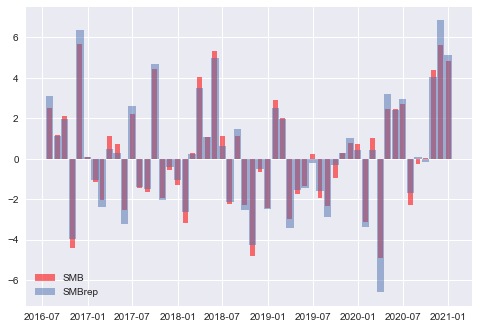

In [113]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.bar(FF.index, FF.SMB, width=20, alpha=0.55, color='red')
plt.bar(df_REP.index, df_REP.SMBrep, width=30, alpha=0.5)
plt.legend(['SMB','SMBrep'])
plt.show()

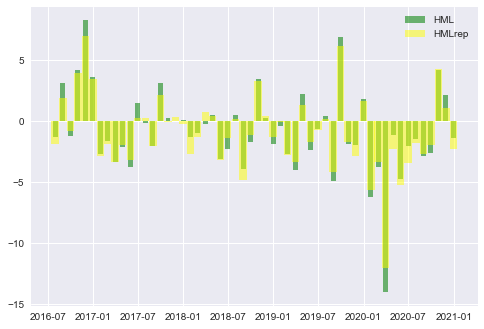

In [114]:
plt.bar(FF.index, FF.HML, width=20, alpha=0.55, color='green')
plt.bar(df_REP.index, df_REP.HMLrep, width=30, alpha=0.5, color='yellow')
plt.legend(['HML','HMLrep'])
plt.show()

In [116]:
FF.join(df_REP).drop(['Mkt-RF','RF'],axis=1).corr()
# SMB 與 我們自己做的 SMBrep 相關性達 99% => GOOD replication!
# HML 與 我們自己做的 HMLrep 相關性達 98% => GOOD replication!

,SMB,HML,SMBrep,HMLrep
SMB,1.000000,0.280485,0.986374,0.222325
HML,0.280485,1.000000,0.369870,0.982383
SMBrep,0.986374,0.369870,1.000000,0.296754
HMLrep,0.222325,0.982383,0.296754,1.000000


## 跟特定 ranking portfolio 比較

In [117]:
mebm6 = pdr.get_data_famafrench('6_Portfolios_2x3', start=df_REP.index.astype(str)[0], end=df_REP.index.astype(str)[-1])
print(mebm6['DESCR'])


6 Portfolios 2x3
----------------

This file was created by CMPT_ME_BEME_OP_INV_RETS using the 202110 CRSP database. It contains value- and equal-weighted returns for portfolios formed on ME and BEME. The portfolios are constructed at the end of June. BEME is book value at the last fiscal year end of the prior calendar year divided by ME at the end of December of the prior year. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2021 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (54 rows x 6 cols)
  1 : Average Equal Weighted Returns -- Monthly (54 rows x 6 cols)
  2 : Average Value Weighted Returns -- Annual (5 rows x 6 cols)
  3 : Average Equal Weighted Returns -- Annual (5 rows x 6 cols)
  4 : Number of Firms in Portfolios (54 rows x 6 cols)
  5 : Average Market Cap (54 rows x 6 cols)
  6 : For port

In [118]:
mebm6[0].head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
Date,,,,,,
2016-07,7.0391,5.6291,5.6866,4.9023,2.2617,3.6699
2016-08,1.3009,2.7039,3.2145,-0.4301,0.2545,3.8763
2016-09,3.2742,1.2982,1.7466,0.4419,-0.0827,-0.4423
2016-10,-8.1473,-5.1820,-3.0105,-2.0245,-2.1588,1.0863
2016-11,9.1400,12.4935,14.9845,1.9783,5.0788,12.5522


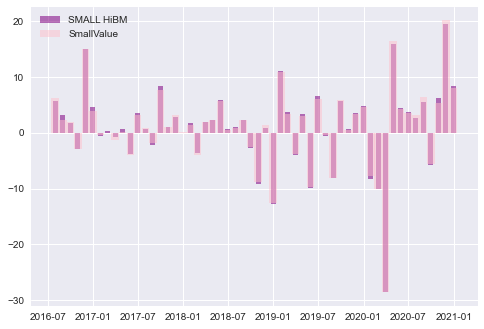

In [119]:
plt.bar(RET_port.index, mebm6[0]['SMALL HiBM'], width=20, alpha=0.55, color='purple')
plt.bar(RET_port.index, RET_port.SmallValue, width=30, alpha=0.5, color='pink')
plt.legend(['SMALL HiBM','SmallValue'])
plt.show()

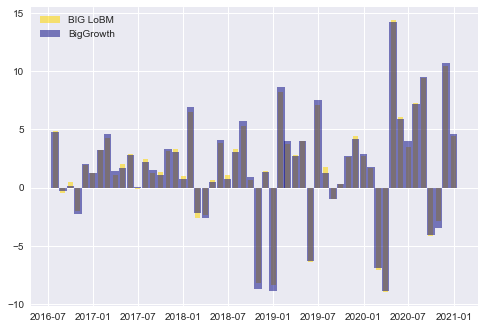

In [120]:
plt.bar(RET_port.index, mebm6[0]['BIG LoBM'], width=20, alpha=0.55, color='gold')
plt.bar(RET_port.index, RET_port.BigGrowth, width=30, alpha=0.5, color='navy')
plt.legend(['BIG LoBM','BigGrowth'])
plt.show()